# 2d mapping of arrests and shootings in NYC

The aim of this part of the project is to model a map predicting the relative number of incidents (arrests/shootings) in different neighborhoods in New York City. The idea is to look at the dataset as a set of samples: we produce a map for each year (calculate the yearly incidents count for neighborhoods) and each map is a different sample.

We will consider the generalized lasso problem, which minimizes the function
$$
\frac12 ||y − X \beta ||_2^2 + \lambda \, ||D \beta||_1.
$$

In our case X is the matrix of ones, while the penalty matrix D is the incidence matrix of the graph of NYC neighborhoods (NTAs), with centroids of the NTAs as nodes and edges connecting the neighboring areas. We are looking for the vector $\beta$ minimizing the above fuction, which will give the optimal map (its coefficients are the optimal values of incidents count for each neighborhood). The variable y is a matrix with rows containing maps for different years. The regularization parameter lambda is chosen with the help of the 5-fold cross validation procedure, where in each fold a different subset of maps (rows of y) plays the role of the validation set. In order to find the solution of the optimization problem we will use CVXPY language for complex optimization problems. In particular, the Splitting Conic Solver - a numerical optimization ADMM-based package will be applied. 

## Data preparation

In [2]:
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random 

Read the GeoJSON file with 262 Neighborhood Tabulation Areas (NTAs):

In [3]:
gdf = gpd.read_file('2020 Neighborhood Tabulation Areas (NTAs).geojson')
nta_count=gdf.shape[0]

Adjacency and incidence matrices:

In [4]:
A=np.zeros((nta_count, nta_count))
for i in range(nta_count):
    for j in range(nta_count):
        if i!=j:
            polygon1 = gdf.loc[i, 'geometry']
            polygon2 = gdf.loc[j, 'geometry']
            if shapely.overlaps(polygon1, polygon2) or shapely.touches(polygon1, polygon2):
                A[i,j]=1

def adjacency_to_incidence(adj_matrix):
    num_vertices = adj_matrix.shape[0]
    edges = []

    # Identify all edges in the graph
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if adj_matrix[i, j] != 0:
                edges.append((i, j))

    num_edges = len(edges)
    incidence_matrix = np.zeros((num_edges, num_vertices))

    # Create the incidence matrix
    for k, (i, j) in enumerate(edges):
        incidence_matrix[k, i] = 1
        incidence_matrix[k, j] = -1

    return incidence_matrix

In=adjacency_to_incidence(A)
In.shape

(651, 262)

Arrest historic data 


In [5]:
arrestH = pd.read_csv("NYPD_Arrests_Data__Historic_.csv") 
lat='Latitude'
lng='Longitude'
arrestH=arrestH[(~arrestH[lat].isna() & ~arrestH[lng].isna())] 
arrestH['ARREST_DATE'] = pd.to_datetime(arrestH['ARREST_DATE'], format='%m/%d/%Y')
arrestH = arrestH[arrestH[lat]< 41]

Shooting historic data

In [6]:
shootingH = pd.read_csv("NYPD_Shooting_Incident_Data__Historic_.csv") 
shootingH=shootingH[(~shootingH[lat].isna() & ~shootingH[lng].isna())] 
shootingH['OCCUR_DATE'] = pd.to_datetime(shootingH['OCCUR_DATE'], format='%m/%d/%Y')
gdf = gpd.read_file('2020 Neighborhood Tabulation Areas (NTAs).geojson')

We will look at the maps with relative percentage of incidents (number of arrests/shootings in the area divided by the total number of the incidents in a given year, multiplied by 100) - in this way we can compare relatively dangerous areas in different years from 2006 to 2023.    
To this end we define the matrix Y_m with rows that are the percentage of incidents for all NTA in a given year.

In [7]:
years_list = range(2006,2024)
Y_m = np.empty((len(years_list), nta_count))

for i, year_arr in enumerate(years_list):

    arrest_i = arrestH.loc[(arrestH['ARREST_DATE'].dt.year == year_arr)]
    total_nb = arrest_i.shape[0]
    geometry = [shapely.Point(xy) for xy in zip(arrest_i[lng], arrest_i[lat])]
    arrest_i_gdf = gpd.GeoDataFrame(arrest_i, geometry=geometry, crs='EPSG:4326')

    # Perform a spatial join to count the number of points within each polygon
    joined_gdf = gpd.sjoin(gdf, arrest_i_gdf, how='inner', predicate='contains')

    # Count the number of points in each polygon
    polygon_counts = joined_gdf.groupby('nta2020').size().reset_index(name='point_count')
 
    # Merge the counts back to the original GeoDataFrame
    gdf1 = pd.merge(gdf, polygon_counts, how='left', on='nta2020')
    gdf1['point_count'] = gdf1['point_count'].fillna(0) /total_nb * 100
    
    Y_m[i,:] = gdf1['point_count'].values 

Similarly for the shooting data:

In [8]:
Y_m2 = np.empty((len(years_list), nta_count))
for i, year_arr in enumerate(years_list):

    shooting_y = shootingH.loc[(shootingH['OCCUR_DATE'].dt.year == year_arr)]
    total_nb = shooting_y.shape[0]

    geometry = [shapely.Point(xy) for xy in zip(shooting_y[lng], shooting_y[lat])]
    shooting_gdf = gpd.GeoDataFrame(shooting_y, geometry=geometry, crs='EPSG:4326')

    joined_gdf = gpd.sjoin(gdf, shooting_gdf, how='inner', predicate='contains')
    polygon_counts = joined_gdf.groupby('nta2020').size().reset_index(name='point_count')
    gdf2 = pd.merge(gdf, polygon_counts, how='left', on='nta2020')
    gdf2['point_count'] = gdf2['point_count'].fillna(0) /total_nb * 100
    
    Y_m2[i,:] = gdf2['point_count'].values 

The 1d analysis of crimes in time suggests that the maps from different years should be similar. Indeed, one can verify it by looking at them year by year. 
We plot below the maps from the last year as examples. 

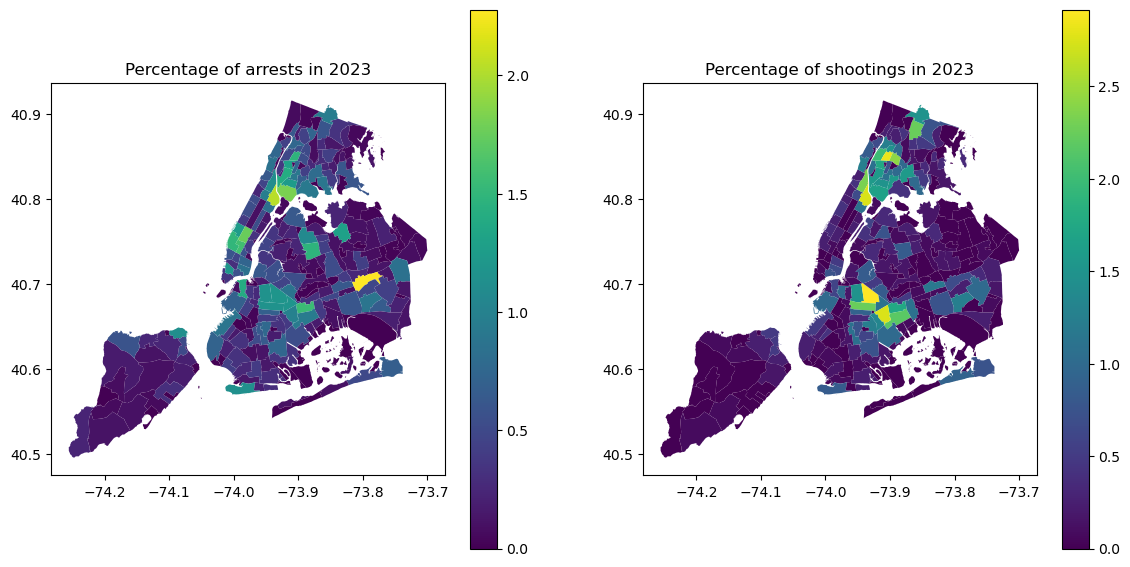

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

gdf1.plot(column='point_count', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title(f"Percentage of arrests in {year_arr}")
gdf2.plot(column='point_count', ax=ax[1], legend=True, cmap='viridis')
ax[1].set_title(f"Percentage of shootings in {year_arr}")
plt.show()

## Fused lasso

Lets divide the set of maps for training and test. We have 18 years, we take 3 years as a test set (16.6%) and with the remaining 15 samples we perform 5-fold cross-validation. 

In [10]:
# arrests
Y_tr, Y_test = train_test_split( Y_m, test_size=0.166, random_state=1)
# shootings
Y_tr2, Y_test2 = train_test_split( Y_m2, test_size=0.166, random_state=1)

We use the cvxpy to solve the optimization problem

In [11]:
import cvxpy as cp

def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2 * (1.0 / X.shape[1]) 

def regularizer(beta):
    return cp.norm1(beta) 

def difference_pen(beta):
    return cp.norm1(In @ beta.T)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * difference_pen(beta) # + lambd * regularizer(beta) 

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value


In [12]:
def fused_lasso(Y_t, Y_val, lambd_values):
    n =Y_t.shape[1] 
    Xn = np.ones((Y_t.shape[0],1))
    beta = cp.Variable((1,n))
    lambd = cp.Parameter(nonneg=True)
    problem = cp.Problem(cp.Minimize(objective_fn(Xn, Y_t, beta, lambd)))
 
    beta_values = []
    train_errors = []
    test_errors = []
    X_val = np.ones((Y_val.shape[0],1))
        
    for v in lambd_values:
        lambd.value = v
        problem.solve(verbose=True)
        train_errors.append(mse(Xn, Y_t, beta))
        test_errors.append(mse(X_val, Y_val, beta))
        beta_values.append(beta.value)
    return beta_values, train_errors, test_errors 

In [13]:
def cross_val(Y_train, folds, lambd_values):

    f=folds
    random.seed(1)
    list_ind = np.arange(15)
    random.shuffle(list_ind)
    list_val = [list_ind[i::f] for i in range(f)]
    list_train= [list(set(list_ind) - set(list_val[i])) for i in range(len(list_val))]
    
    Err = np.empty((folds ,len(lambd_values)))

    for i in range(folds):
        Y_val = Y_train[list_val[i]]
        Y_t = Y_train[list_train[i]]

        _ , _ , Err[i,] = fused_lasso(Y_t, Y_val, lambd_values)
        
    return Err

We start with the arrest data. First we perform a test fit to check the proper limits for the values of regularisation parameter lambda.

In [46]:
%%capture
# a try for a subset
lambd_values = np.logspace(-3,1.2,20)
beta_values, train_errors, test_errors = fused_lasso(Y_tr[0:3], Y_tr[3:6], lambd_values)

(CVXPY) Jan 03 11:01:56 AM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 03 11:01:56 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 03 11:01:56 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 03 11:01:56 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jan 03 11:01:56 AM: Compiling problem (target solver=SCS).
(CVXPY) Jan 03 11:01:56 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 03 11:01:56 AM: Applying reduction Dcp2Cone
(CVXPY) Jan 03 11:01:56 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 03 11:01:56 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Jan 03 11:01:56 AM: Applying reduction SCS
(CVXPY) Jan 03 11:01:56 AM: Finished problem compilation (took 7.701e-02 seconds).
(CVXPY) Jan 03 11:01:56 AM: (Subsequent compilations of this problem, using the same arguments, should take less time

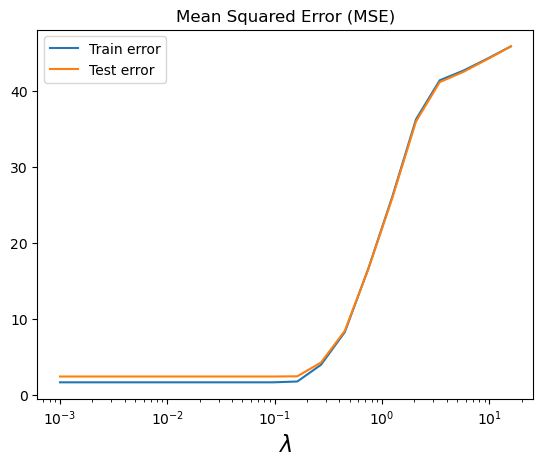

In [44]:
def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()

plot_train_test_errors(train_errors, test_errors, lambd_values)

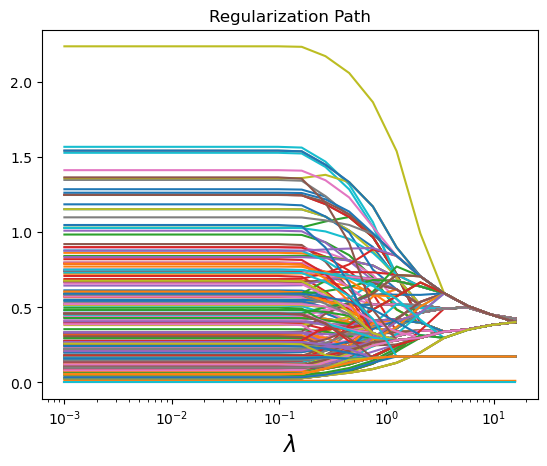

In [45]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, beta_values)

The above range of lambda should cover the interesting values. Next we perform the 5-fold cross-validation in order to choose the optimal lambda.

In [16]:
lambd_values = np.logspace(-3,1.2,20) 
Err = cross_val(Y_tr, 5, lambd_values)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 01 05:21:00 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 01 05:21:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 01 05:21:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 01 05:21:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 01 05:21:00 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 01 05:21:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 01 05:21:00 PM: Applyin

Calculating the mean value of the MSE over all folds and the optimal lambda:

In [17]:
def optimal_lambda(lambd_values, err):
    # mean and standard deviation
    CV_err = np.mean(err, axis=0)
    CV_sd = np.std(err, axis=0 )
    # lambda_min
    ind_min = np.argmin(CV_err)
    lambda_min = lambd_values[ind_min]
    #lambda_1se
    err_1se = min(CV_err) + CV_sd[np.argmin(CV_err)]
    ind_1se = np.argmax(CV_err[CV_err < err_1se])
    lambda_1se = lambd_values[ind_1se]
    return lambda_min, lambda_1se, min(CV_err), CV_err[ind_1se]

lambd_values = np.logspace(-3,1.2,20) 
lambda_min, lambda_1se, errCV_min, errCV_1se  = optimal_lambda(lambd_values, Err)

Plot of the cross-validation error:

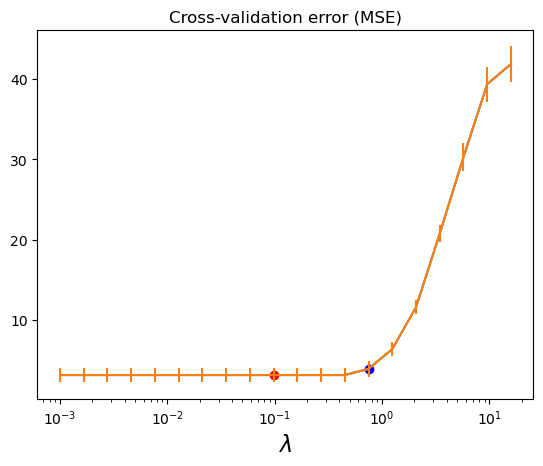

In [18]:
def plot_cross_val(lambd_values, err, lambda_min, lambda_1se, errCV_min, errCV_1se):
    CV_err = np.mean(err, axis=0)
    CV_sd = np.std(err, axis=0 )
    #plot
    plt.plot(lambd_values, CV_err)
    plt.errorbar(lambd_values, CV_err, yerr = CV_sd)
    plt.xscale("log")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Cross-validation error (MSE)")
    plt.scatter(lambda_min, errCV_min, color="red")
    plt.scatter(lambda_1se, errCV_1se , color="blue")
    plt.show()

plot_cross_val(lambd_values, Err, lambda_min, lambda_1se, errCV_min, errCV_1se)

Finally, we train the model on the full train set with lambdas chosen by the cross-validation and test it on the test set:

In [19]:
lambd_values = [lambda_min, lambda_1se, 3, 8]
beta_values, train_errors, test_errors = fused_lasso(Y_tr, Y_test, lambd_values)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 01 05:56:41 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 01 05:56:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 01 05:56:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 01 05:56:41 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 01 05:56:41 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 01 05:56:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 01 05:56:41 PM: Applyin

In [20]:
print(f"CV error for lamda.min= {round(lambda_min,3)}: {round(errCV_min,2)}, \nCV error for lambda.1se= {round(lambda_1se,3)}: {round(errCV_1se,2)}")
print(f"train errors for lambda_min and lambda_1se: {train_errors[:2]}")
print(f"test errors for lambda_min and lambda_1se: {test_errors[:2]}")

CV error for lamda.min= 0.098: 3.16, 
CV error for lambda.1se= 0.748: 3.92
train errors for lambda_min and lambda_1se: [1.338615923207914, 1.5483442131820384]
test errors for lambda_min and lambda_1se: [2.1956113486470414, 2.283738042823133]


Map of the arrests for the lambda given by the one-standard-error-rule:

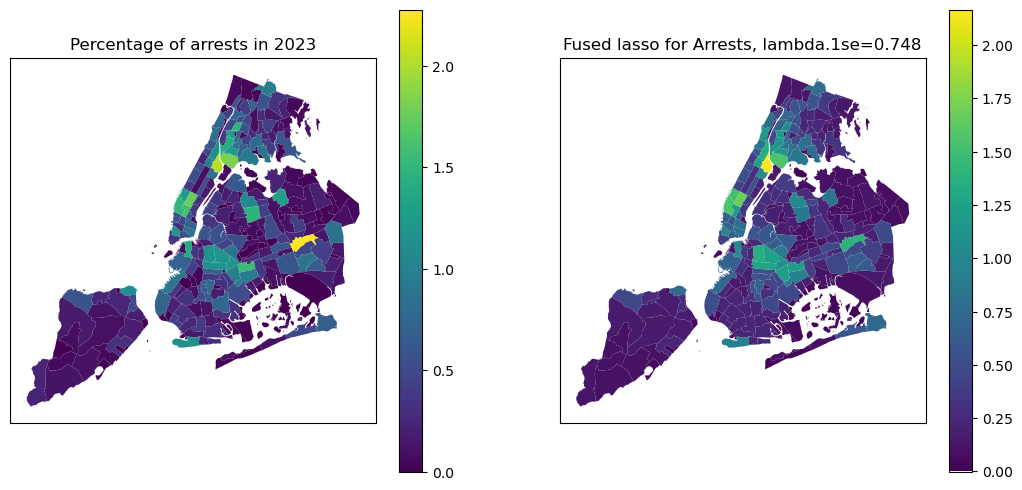

In [21]:
i= 1
gdf1['fused_lasso']= beta_values[i].T

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
gdf1.plot(column='point_count', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title(f"Percentage of arrests in {year_arr}")
ax[0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
gdf1.plot(column='fused_lasso', ax=ax[1], legend=True, cmap='viridis')
ax[1].set_title(f'Fused lasso for Arrests, lambda.1se={round(lambd_values[i],3)}')
ax[1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
plt.show()

The optimal regularization parameter is small and the learnt fused map is very similar to the original maps from different years.  
This was expected since the dangerous areas are strictly localised in space, and their position is rather stable in time. 

If we fix the regularisation parameter to a large value we get a map that is more blurred. Such a map is not an optimal solution to our problem of modeling the dangerous areas of the city, but it shows the general differences between boroughs, confirming what we arleady saw in the 1d time dependence analysis of the crime data.  

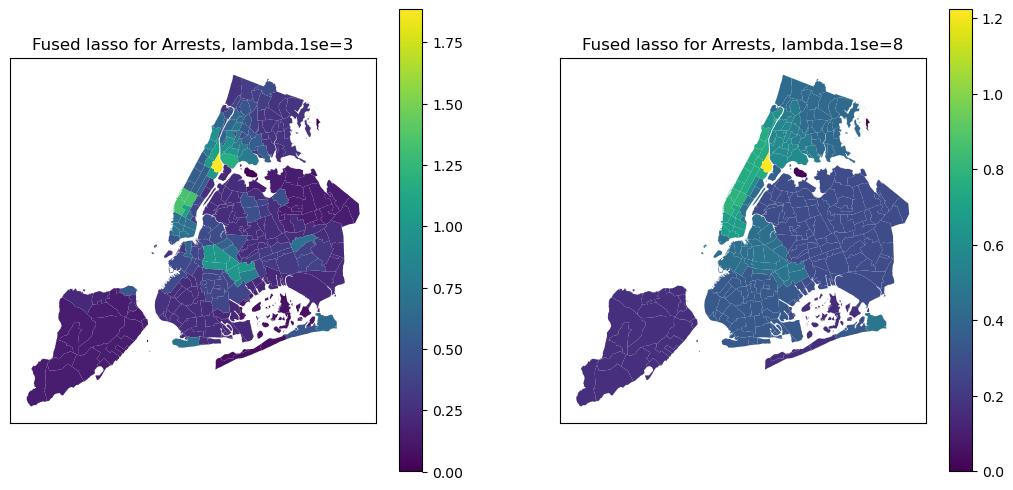

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
i= 2
gdf1['fused_lasso']= beta_values[i].T
gdf1.plot(column='fused_lasso', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title(f'Fused lasso for Arrests, lambda.1se={round(lambd_values[i],3)}')
ax[0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 

i= 3
gdf1['fused_lasso']= beta_values[i].T
gdf1.plot(column='fused_lasso', ax=ax[1], legend=True, cmap='viridis')
ax[1].set_title(f'Fused lasso for Arrests, lambda.1se={round(lambd_values[i],3)}')
ax[1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
plt.show()

In order to obtain a map showing the most probable percentage of shooting incidents we can follow the same steps as above. We perform the 5-fold cross-validation and pick up the lambda given by the one-standard-error-rule:  

In [23]:
lambd_values2 = np.logspace(-3,1,20) 
Err2 = cross_val(Y_tr2, 5, lambd_values2)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 01 06:00:50 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 01 06:00:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 01 06:00:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 01 06:00:50 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 01 06:00:50 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 01 06:00:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 01 06:00:50 PM: Applyin

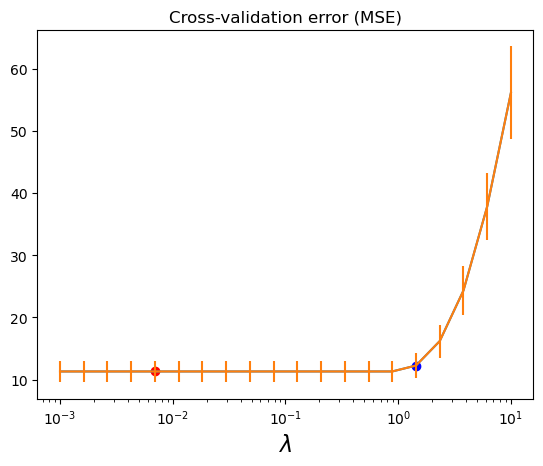

In [24]:
lambd_values2 = np.logspace(-3,1,20)
lambda_min2, lambda_1se2, errCV_min2, errCV_1se2  = optimal_lambda(lambd_values2, Err2)
plot_cross_val(lambd_values2, Err2, lambda_min2, lambda_1se2, errCV_min2, errCV_1se2)

Next we train the model on the full train set with lambda chosen by the cross-validation and test it on the test set:

In [25]:
lambd_values2 = [lambda_min2, lambda_1se2]
beta_values2, train_errors, test_errors = fused_lasso(Y_tr2, Y_test2, lambd_values2)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 01 06:42:00 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 01 06:42:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 01 06:42:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 01 06:42:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 01 06:42:00 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 01 06:42:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 01 06:42:00 PM: Applyin

In [26]:
print(f"CV error for lamda.min= {round(lambda_min2,3)}: {round(errCV_min2,2)}, \nCV error for lambda.1se= {round(lambda_1se2,3)}: {round(errCV_1se2,2)}")
print(f"train errors for lambda_min and lambda_1se: {train_errors}")
print(f"test errors for lambda_min and lambda_1se: {test_errors}")

CV error for lamda.min= 0.007: 11.31, 
CV error for lambda.1se= 1.438: 12.26
train errors for lambda_min and lambda_1se: [3.5498730174358224, 3.5498847419116646]
test errors for lambda_min and lambda_1se: [9.154672965061144, 9.154684396143727]


Map of the shootings for the lambda given by the one-standard-error-rule:

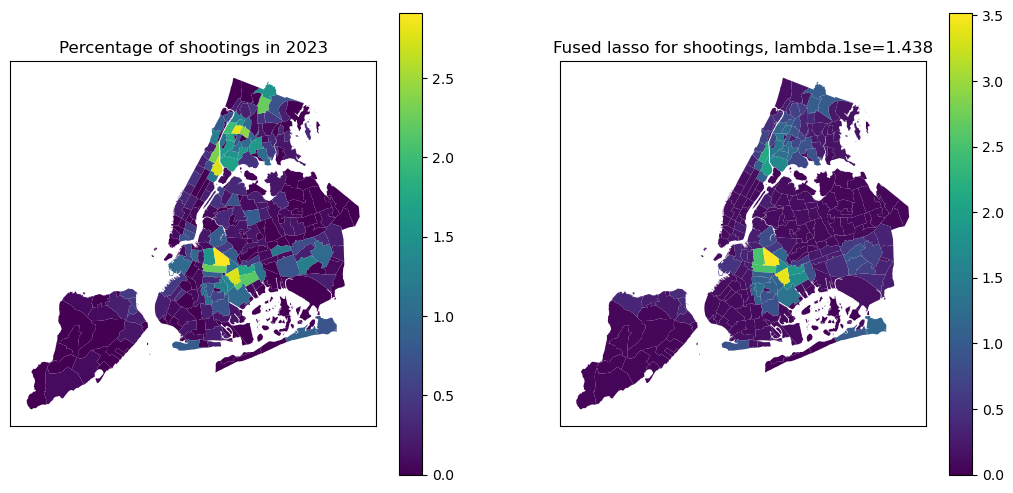

In [27]:
i= 1
gdf2['fused_lasso']= beta_values2[i].T

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
gdf2.plot(column='point_count', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title(f"Percentage of shootings in {year_arr}")
ax[0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
gdf2.plot(column='fused_lasso', ax=ax[1], legend=True, cmap='viridis')
ax[1].set_title(f'Fused lasso for shootings, lambda.1se={round(lambd_values2[i],3)}')
ax[1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
plt.show()

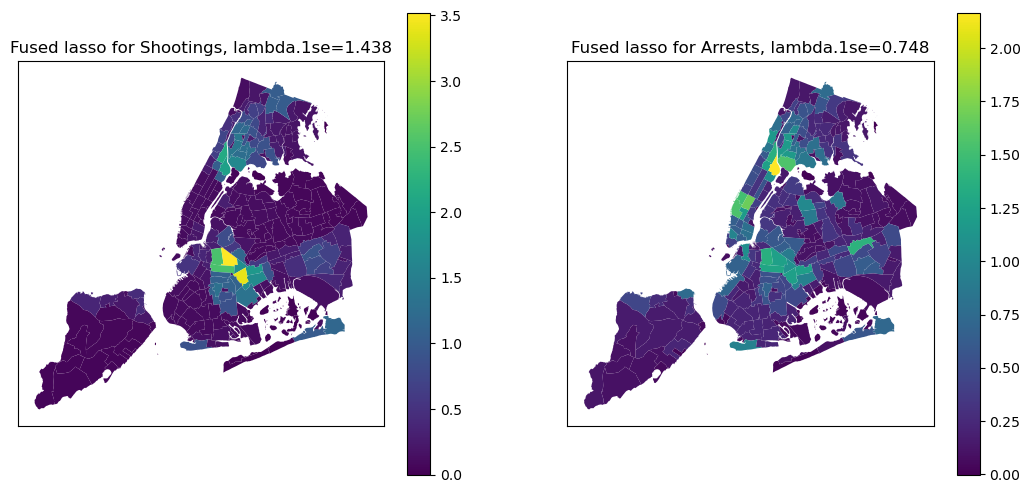

In [42]:
i= 1
gdf1['fused_lasso']= beta_values[i].T
gdf2['fused_lasso']= beta_values2[i].T

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
gdf2.plot(column='fused_lasso', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title(f'Fused lasso for Shootings, lambda.1se={round(lambd_values2[i],3)}')
ax[0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
gdf1.plot(column='fused_lasso', ax=ax[1], legend=True, cmap='viridis')
ax[1].set_title(f'Fused lasso for Arrests, lambda.1se={round(lambd_values[i],3)}')
ax[1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)  
plt.show()

Also in this case the fused map is similar to the original ones. The areas of high shootings probability are very well localised, often not far from much safer places and they do not vary much in time. This is a typical feature of the US cities.  


## The scaled data

Since there are few neighborhoods with very high relative number of shootings and many with much smaller, it is difficult to see from the map the differences between safer areas. In order to underline these differences we can look at the map of transformed values in the logarithmic scale.

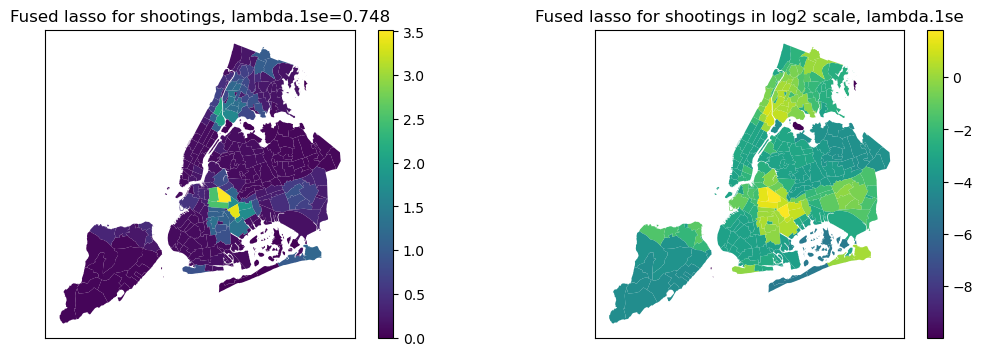

In [29]:
i= 1
gdf2['fused_lasso_L']= (np.log2(beta_values2[i] + 0.001)).T

fig, ax = plt.subplots(1, 2, figsize=(13,4))
gdf2.plot(column='fused_lasso', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title(f'Fused lasso for shootings, lambda.1se={round(lambd_values[i],3)}')
ax[0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
gdf2.plot(column='fused_lasso_L', ax=ax[1], legend=True, cmap='viridis')
ax[1].set_title(f'Fused lasso for shootings in log2 scale, lambda.1se')
ax[1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
plt.show()

We can also first transform the original maps from each year and fit a model to the log scaled data.

In [14]:
Y_m2L = np.log2(Y_m2+ 0.0001)
Y_tr2L, Y_test2L = train_test_split( Y_m2L, test_size=0.166, random_state=1)

In [31]:
# a try for a subset
lambd_values2L = np.logspace(-2,2, 4)
beta_values2L, train_errors2L, test_errors2L = fused_lasso(Y_tr2L[0:3], Y_tr2L[3:6], lambd_values2L)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 01 06:42:55 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 01 06:42:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 01 06:42:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 01 06:42:55 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 01 06:42:55 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 01 06:42:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 01 06:42:55 PM: Applyin

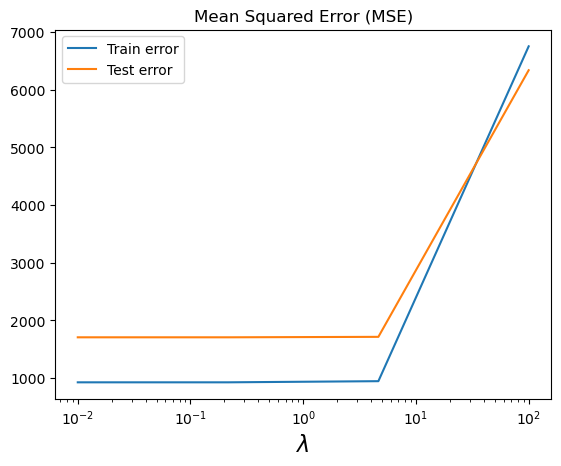

In [32]:
plot_train_test_errors(train_errors2L, test_errors2L, lambd_values2L)

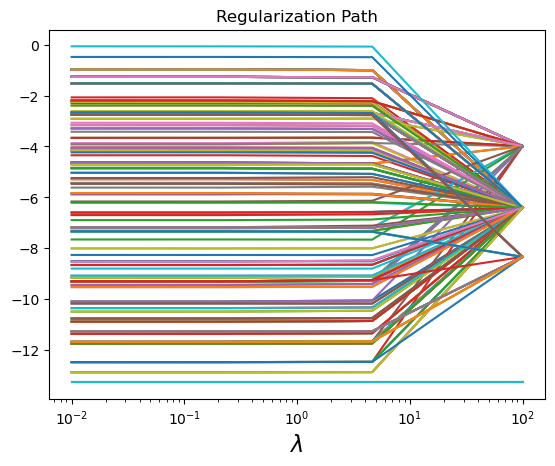

In [33]:
plot_regularization_path(lambd_values2L, beta_values2L)

We fit the model for lambda values between $10^{-1}$ and $10^{1.5}$:

In [15]:
lambd_values2L = np.logspace(-1,1.5,20) 
Err2L = cross_val(Y_tr2L, 5, lambd_values2L)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 05:16:00 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 05:16:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:16:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:16:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:16:00 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 05 05:16:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 05 05:16:00 PM: Applyin

-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:16:09 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constraints m: 38977
cones: 	  l: linear vars: 1302
	  s: psd vars: 37675, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 7324, nnz(P): 1
--------------------------------------------------------------

(CVXPY) Jan 05 05:16:16 PM: Optimal value: 4.582e+03
(CVXPY) Jan 05 05:16:16 PM: Compilation took 4.544e-03 seconds
(CVXPY) Jan 05 05:16:16 PM: Solver (including time spent in interface) took 2.107e+00 seconds
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 05:16:16 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 05:16:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:16:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:16:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------

------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constraints m: 38977
cones: 	  l: linear vars: 1302
	  s: psd vars: 37675, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 7324, nnz(P): 1
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 3.39e+00  1.31e+00  1.46e+03  4.34e+03  1.00e-01  2.52e-02 
   100| 1.85e-04  3.71e-04  1.64e-02  5.45e+03  1.00e-01  1.40e+00 
------------------------------------

(CVXPY) Jan 05 05:16:25 PM: Compilation took 6.359e-03 seconds
(CVXPY) Jan 05 05:16:25 PM: Solver (including time spent in interface) took 2.139e+00 seconds
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 05:16:25 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 05:16:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:16:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:16:25 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:16:25 PM: Using cached ASA m

   250| 1.87e-04  8.46e-05  1.57e-03  1.06e+04  1.00e-01  3.38e+00 
------------------------------------------------------------------
status:  solved
timings: total: 3.38e+00s = setup: 1.56e-02s + solve: 3.37e+00s
	 lin-sys: 7.47e-02s, cones: 3.27e+00s, accel: 3.93e-03s
------------------------------------------------------------------
objective = 10593.771471
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:16:35 PM: Problem status: optimal
(CVXPY) Jan 05 05:16:35 PM: Optimal value: 1.059e+04
(CVXPY) Jan 05 05:16:35 PM: Compilation took 7.160e-03 seconds
(CVXPY) Jan 05 05:16:35 PM: Solver (including time spent in interface) took 3.387e+00 seconds
                                     CVXPY                         

(CVXPY) Jan 05 05:16:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:16:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:16:47 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:16:47 PM: Finished problem compilation (took 2.130e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:16:47 PM: Invoking solver SCS  to obtain a solution.
-------------------------------------------

   250| 1.23e-01  4.55e-01  5.33e-01  3.25e+04  1.00e-01  3.37e+00 
   500| 3.54e-02  3.19e-02  5.97e-03  3.26e+04  1.00e-01  6.66e+00 
   675| 9.45e-04  3.29e-04  2.41e-04  3.26e+04  1.00e-01  9.00e+00 
------------------------------------------------------------------
status:  solved
timings: total: 9.00e+00s = setup: 1.07e-02s + solve: 8.99e+00s
	 lin-sys: 2.00e-01s, cones: 8.74e+00s, accel: 1.00e-02s
------------------------------------------------------------------
objective = 32575.078387
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:17:12 PM: Problem status: optimal
(CVXPY) Jan 05 05:17:12 PM: Optimal value: 3.258e+04
(CVXPY) Jan 05 05:17:12 PM: Compilation took 4.548e-03 seconds
(CVXPY) Jan 05 05:17:12 P

(CVXPY) Jan 05 05:17:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:17:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:17:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:17:37 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 05 05:17:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 05 05:17:37 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 05 05:17:37 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 05 05:17:37 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jan 05 05:17:37 PM: Applying reduction SCS
(CVXPY) Jan 05 05:17:37 PM: Finished problem compilat

   150| 4.38e-04  1.24e-03  2.22e-02  4.30e+03  1.00e-01  2.12e+00 
------------------------------------------------------------------
status:  solved
timings: total: 2.12e+00s = setup: 1.01e-02s + solve: 2.11e+00s
	 lin-sys: 4.48e-02s, cones: 2.05e+00s, accel: 2.32e-03s
------------------------------------------------------------------
objective = 4304.971047
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:17:48 PM: Problem status: optimal
(CVXPY) Jan 05 05:17:48 PM: Optimal value: 4.305e+03
(CVXPY) Jan 05 05:17:48 PM: Compilation took 2.100e-03 seconds
(CVXPY) Jan 05 05:17:48 PM: Solver (including time spent in interface) took 2.121e+00 seconds
                                     CVXPY                          

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:17:52 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:17:52 PM: Finished problem compilation (took 2.015e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:17:52 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constra

   100| 3.38e-04  3.88e-04  1.34e-02  5.44e+03  1.00e-01  1.41e+00 
------------------------------------------------------------------
status:  solved
timings: total: 1.41e+00s = setup: 1.07e-02s + solve: 1.40e+00s
	 lin-sys: 3.07e-02s, cones: 1.36e+00s, accel: 8.51e-04s
------------------------------------------------------------------
objective = 5441.663479
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:17:57 PM: Problem status: optimal
(CVXPY) Jan 05 05:17:57 PM: Optimal value: 5.442e+03
(CVXPY) Jan 05 05:17:57 PM: Compilation took 2.978e-03 seconds
(CVXPY) Jan 05 05:17:57 PM: Solver (including time spent in interface) took 1.410e+00 seconds
                                     CVXPY                          

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:18:01 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:18:01 PM: Finished problem compilation (took 3.769e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:18:01 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constra

   250| 2.91e-03  1.12e-03  1.75e-02  1.06e+04  1.00e-01  3.39e+00 
   450| 1.02e-05  6.16e-06  1.54e-04  1.06e+04  1.00e-01  6.02e+00 
------------------------------------------------------------------
status:  solved
timings: total: 6.02e+00s = setup: 7.36e-03s + solve: 6.01e+00s
	 lin-sys: 1.37e-01s, cones: 5.84e+00s, accel: 6.55e-03s
------------------------------------------------------------------
objective = 10612.174951
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:18:15 PM: Problem status: optimal
(CVXPY) Jan 05 05:18:15 PM: Optimal value: 1.061e+04
(CVXPY) Jan 05 05:18:15 PM: Compilation took 2.470e-03 seconds
(CVXPY) Jan 05 05:18:15 PM: Solver (including time spent in interface) took 6.022e+00 seconds

(CVXPY) Jan 05 05:18:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:18:28 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:18:28 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:18:28 PM: Finished problem compilation (took 9.457e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:18:28 PM: Invoking solver SCS  to obtain a solution.
-------------------------------------------

   250| 1.50e-01  4.59e-01  3.91e-01  3.27e+04  1.00e-01  3.34e+00 
   500| 3.57e-02  4.60e-02  6.30e-03  3.27e+04  1.00e-01  6.61e+00 
   700| 1.67e-04  1.67e-05  1.07e-03  3.27e+04  1.00e-01  9.29e+00 
------------------------------------------------------------------
status:  solved
timings: total: 9.29e+00s = setup: 9.59e-03s + solve: 9.28e+00s
	 lin-sys: 2.07e-01s, cones: 9.02e+00s, accel: 1.05e-02s
------------------------------------------------------------------
objective = 32696.001381
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:18:58 PM: Problem status: optimal
(CVXPY) Jan 05 05:18:58 PM: Optimal value: 3.270e+04
(CVXPY) Jan 05 05:18:58 PM: Compilation took 2.426e-03 seconds
(CVXPY) Jan 05 05:18:58 P

(CVXPY) Jan 05 05:19:37 PM: Compilation took 3.754e-03 seconds
(CVXPY) Jan 05 05:19:37 PM: Solver (including time spent in interface) took 2.811e+01 seconds
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 05:19:37 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 05:19:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:19:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:19:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:19:37 PM: Compiling problem 

(CVXPY) Jan 05 05:19:47 PM: Finished problem compilation (took 2.174e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:19:47 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constraints m: 38977
cones: 	  l: linear vars: 1302
	  s: psd vars: 37675, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz

(CVXPY) Jan 05 05:19:54 PM: Optimal value: 4.651e+03
(CVXPY) Jan 05 05:19:54 PM: Compilation took 1.993e-03 seconds
(CVXPY) Jan 05 05:19:54 PM: Solver (including time spent in interface) took 2.085e+00 seconds
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 05:19:54 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 05:19:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:19:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:19:54 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------

------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constraints m: 38977
cones: 	  l: linear vars: 1302
	  s: psd vars: 37675, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 7324, nnz(P): 1
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 3.39e+00  1.31e+00  1.47e+03  4.38e+03  1.00e-01  4.15e-02 
   100| 3.20e-04  3.63e-04  1.43e-02  5.48e+03  1.00e-01  1.44e+00 
------------------------------------

(CVXPY) Jan 05 05:20:04 PM: Compilation took 2.110e-03 seconds
(CVXPY) Jan 05 05:20:04 PM: Solver (including time spent in interface) took 3.050e+00 seconds
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 05:20:04 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 05:20:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:20:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:20:04 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:20:04 PM: Using cached ASA m

------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constraints m: 38977
cones: 	  l: linear vars: 1302
	  s: psd vars: 37675, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 7324, nnz(P): 1
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.54e+01  4.96e+00  3.64e+04 -9.42e+03  1.00e-01  3.59e-02 
   250| 5.07e-03  1.31e-03  1.57e-02  1.04e+04  1.00e-01  3.43e+00 
   350| 1.69e-04  4.64e-05  3.19e-05

(CVXPY) Jan 05 05:20:30 PM: Optimal value: 1.571e+04
(CVXPY) Jan 05 05:20:30 PM: Compilation took 5.938e-03 seconds
(CVXPY) Jan 05 05:20:30 PM: Solver (including time spent in interface) took 7.467e+00 seconds
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 05:20:30 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 05:20:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:20:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:20:30 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------

(CVXPY) Jan 05 05:20:55 PM: Finished problem compilation (took 3.571e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:20:55 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constraints m: 38977
cones: 	  l: linear vars: 1302
	  s: psd vars: 37675, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz

   250| 2.35e-01  1.05e+00  2.11e-01  4.64e+04  1.00e-01  3.37e+00 
   500| 1.22e-01  1.56e-01  2.39e-02  4.66e+04  1.00e-01  6.67e+00 
   750| 5.41e-02  4.12e-02  1.25e-02  4.66e+04  1.00e-01  9.95e+00 
   900| 8.21e-04  2.37e-03  2.80e-03  4.66e+04  1.00e-01  1.20e+01 
------------------------------------------------------------------
status:  solved
timings: total: 1.20e+01s = setup: 9.69e-03s + solve: 1.20e+01s
	 lin-sys: 2.66e-01s, cones: 1.16e+01s, accel: 1.29e-02s
------------------------------------------------------------------
objective = 46597.258558
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:26 PM: Problem status: optimal
(CVXPY) Jan 05 05:21:26 PM: Optimal value: 4.660e+04
(CVXPY) Jan 05 05:21

(CVXPY) Jan 05 05:21:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:21:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:21:34 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:34 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:21:34 PM: Finished problem compilation (took 1.105e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:34 PM: Inv

   125| 6.25e-04  9.93e-04  3.86e-03  4.37e+03  1.00e-01  1.78e+00 
------------------------------------------------------------------
status:  solved
timings: total: 1.78e+00s = setup: 1.04e-02s + solve: 1.77e+00s
	 lin-sys: 3.79e-02s, cones: 1.72e+00s, accel: 2.08e-03s
------------------------------------------------------------------
objective = 4374.739426
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:41 PM: Problem status: optimal
(CVXPY) Jan 05 05:21:41 PM: Optimal value: 4.375e+03
(CVXPY) Jan 05 05:21:41 PM: Compilation took 2.594e-03 seconds
(CVXPY) Jan 05 05:21:41 PM: Solver (including time spent in interface) took 1.778e+00 seconds
                                     CVXPY                          

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:44 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:21:44 PM: Finished problem compilation (took 3.237e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:44 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constra

   200| 3.64e-04  1.72e-04  1.83e-03  6.46e+03  1.00e-01  2.78e+00 
------------------------------------------------------------------
status:  solved
timings: total: 2.78e+00s = setup: 5.38e-03s + solve: 2.77e+00s
	 lin-sys: 6.17e-02s, cones: 2.69e+00s, accel: 2.71e-03s
------------------------------------------------------------------
objective = 6455.701445
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:51 PM: Problem status: optimal
(CVXPY) Jan 05 05:21:51 PM: Optimal value: 6.456e+03
(CVXPY) Jan 05 05:21:51 PM: Compilation took 3.201e-03 seconds
(CVXPY) Jan 05 05:21:51 PM: Solver (including time spent in interface) took 2.779e+00 seconds
                                     CVXPY                          

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:59 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:21:59 PM: Finished problem compilation (took 3.210e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:21:59 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constra

   250| 2.31e-02  4.58e-03  2.75e-01  1.59e+04  1.00e-01  3.38e+00 
   500| 4.25e-03  1.50e-03  7.03e-03  1.59e+04  1.00e-01  6.68e+00 
   675| 1.50e-04  2.51e-05  6.89e-05  1.59e+04  1.00e-01  9.01e+00 
------------------------------------------------------------------
status:  solved
timings: total: 9.01e+00s = setup: 1.02e-02s + solve: 9.00e+00s
	 lin-sys: 2.00e-01s, cones: 8.75e+00s, accel: 9.23e-03s
------------------------------------------------------------------
objective = 15921.656467
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:22:21 PM: Problem status: optimal
(CVXPY) Jan 05 05:22:21 PM: Optimal value: 1.592e+04
(CVXPY) Jan 05 05:22:21 PM: Compilation took 3.109e-03 seconds
(CVXPY) Jan 05 05:22:21 P

(CVXPY) Jan 05 05:22:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:22:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:22:50 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:22:50 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:22:50 PM: Finished problem compilation (took 2.551e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:22:50 PM: Inv

------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constraints m: 38977
cones: 	  l: linear vars: 1302
	  s: psd vars: 37675, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 7324, nnz(P): 1
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.28e+02  8.27e+00  2.63e+06 -1.28e+06  1.00e-01  3.10e-02 
   250| 2.27e-01  1.08e+00  2.81e-01  4.73e+04  1.00e-01  3.38e+00 
   500| 1.29e-01  1.23e-01  1.89e-01

   150| 5.29e-04  1.17e-03  8.00e-03  4.31e+03  1.00e-01  2.08e+00 
------------------------------------------------------------------
status:  solved
timings: total: 2.08e+00s = setup: 1.31e-02s + solve: 2.07e+00s
	 lin-sys: 4.45e-02s, cones: 2.01e+00s, accel: 2.86e-03s
------------------------------------------------------------------
objective = 4312.865076
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:23:57 PM: Problem status: optimal
(CVXPY) Jan 05 05:23:57 PM: Optimal value: 4.313e+03
(CVXPY) Jan 05 05:23:57 PM: Compilation took 3.369e-03 seconds
(CVXPY) Jan 05 05:23:58 PM: Solver (including time spent in interface) took 2.086e+00 seconds
                                     CVXPY                          

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:24:02 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:24:02 PM: Finished problem compilation (took 1.671e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:24:02 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constra

   100| 5.71e-04  9.44e-04  4.73e-03  5.13e+03  1.00e-01  1.43e+00 
------------------------------------------------------------------
status:  solved
timings: total: 1.43e+00s = setup: 1.21e-02s + solve: 1.42e+00s
	 lin-sys: 3.10e-02s, cones: 1.38e+00s, accel: 9.10e-04s
------------------------------------------------------------------
objective = 5125.699198
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:24:07 PM: Problem status: optimal
(CVXPY) Jan 05 05:24:07 PM: Optimal value: 5.126e+03
(CVXPY) Jan 05 05:24:07 PM: Compilation took 2.964e-03 seconds
(CVXPY) Jan 05 05:24:07 PM: Solver (including time spent in interface) took 1.437e+00 seconds
                                     CVXPY                          

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:24:11 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:24:11 PM: Finished problem compilation (took 5.331e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:24:11 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 914, constra

   250| 1.94e-03  3.01e-04  3.63e-03  8.82e+03  1.00e-01  3.41e+00 
   350| 2.69e-05  1.19e-05  5.41e-04  8.82e+03  1.00e-01  4.73e+00 
------------------------------------------------------------------
status:  solved
timings: total: 4.73e+00s = setup: 9.68e-03s + solve: 4.73e+00s
	 lin-sys: 1.05e-01s, cones: 4.59e+00s, accel: 5.43e-03s
------------------------------------------------------------------
objective = 8823.070407
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:24:22 PM: Problem status: optimal
(CVXPY) Jan 05 05:24:22 PM: Optimal value: 8.823e+03
(CVXPY) Jan 05 05:24:22 PM: Compilation took 4.065e-03 seconds
(CVXPY) Jan 05 05:24:22 PM: Solver (including time spent in interface) took 4.740e+00 seconds


(CVXPY) Jan 05 05:24:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:24:34 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:24:34 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jan 05 05:24:34 PM: Finished problem compilation (took 5.265e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:24:34 PM: Invoking solver SCS  to obtain a solution.
-------------------------------------------

   250| 1.14e-01  1.91e-01  3.86e-01  2.54e+04  1.00e-01  3.36e+00 
   500| 4.22e-02  2.72e-02  1.81e-02  2.54e+04  1.00e-01  6.65e+00 
   750| 3.78e-03  3.32e-03  3.18e-03  2.54e+04  1.00e-01  9.98e+00 
  1000| 1.76e-03  8.89e-04  1.07e-03  2.54e+04  1.00e-01  1.34e+01 
  1100| 2.08e-04  4.15e-05  1.08e-05  2.54e+04  1.00e-01  1.47e+01 
------------------------------------------------------------------
status:  solved
timings: total: 1.47e+01s = setup: 9.65e-03s + solve: 1.47e+01s
	 lin-sys: 3.26e-01s, cones: 1.43e+01s, accel: 1.59e-02s
------------------------------------------------------------------
objective = 25449.452378
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 05 05:25:10 PM: Problem status: optimal
(CVXP

(CVXPY) Jan 05 05:25:44 PM: Optimal value: 3.912e+04
(CVXPY) Jan 05 05:25:44 PM: Compilation took 3.149e-03 seconds
(CVXPY) Jan 05 05:25:44 PM: Solver (including time spent in interface) took 1.380e+01 seconds
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 05:25:44 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 05:25:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 05:25:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 05:25:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------

In [69]:
def optimal_lambda2(lambd_values, err):
    # mean and standard deviation
    CV_err = np.mean(err, axis=0)
    CV_sd = np.std(err, axis=0 )
    # lambda_min
    ind_min = np.argmin(CV_err)
    lambda_min = lambd_values[ind_min]
    #lambda_1se
    CV_errp = CV_err[ind_min+1:]
    err_1se = min(CV_err) + CV_sd[np.argmin(CV_err)]
    CV_1se = CV_errp[CV_errp < err_1se][-1]
    ind_1se = np.argwhere(CV_err==CV_1se)
    lambda_1se = lambd_values[ind_1se]
    return lambda_min, lambda_1se[0], min(CV_err), CV_err[ind_1se]

In [70]:
lambd_values2L = np.logspace(-1,1.5,20)
lambda_min2L, lambda_1se2L, errCV_min2L, errCV_1se2L  = optimal_lambda2(lambd_values2L, Err2L)

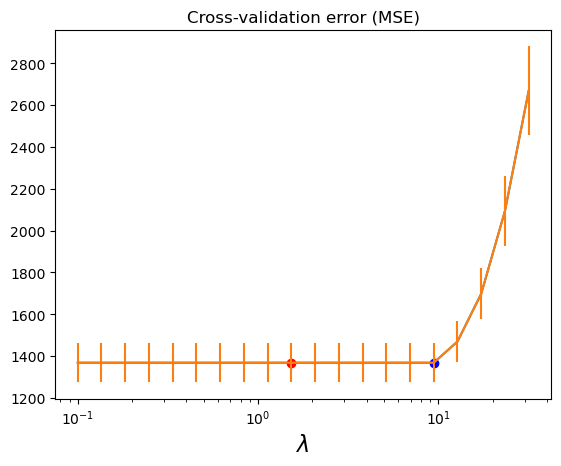

In [71]:
plot_cross_val(lambd_values2L, Err2L, lambda_min2L, lambda_1se2L, errCV_min2L, errCV_1se2L)

In [72]:
lambd_values2L = [lambda_min2L, lambda_1se2L[0]]
beta_values2L, train_errors, test_errors = fused_lasso(Y_tr2L, Y_test2L, lambd_values2L)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 05 06:15:42 PM: Your problem has 262 variables, 0 constraints, and 1 parameters.
(CVXPY) Jan 05 06:15:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 06:15:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 06:15:42 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 06:15:42 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 05 06:15:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 05 06:15:42 PM: Applyin

In [73]:
print(train_errors, test_errors)
print(errCV_min2L, errCV_1se2L)

[281.2049779618656, 281.20499844200157] [1205.0214833551236, 1205.018193578385]
1368.6661422421737 [[1368.6671528]]


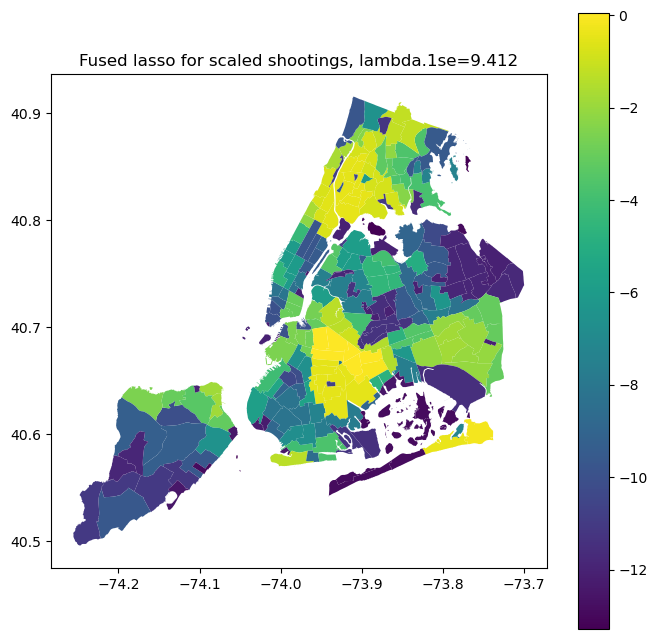

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

i= 1
gdf2['fused_lasso_2L']= beta_values2L[i].T
gdf2.plot(column='fused_lasso_2L', ax=ax, legend=True, cmap='viridis')

plt.title(f'Fused lasso for scaled shootings, lambda.1se={round(lambd_values2L[i],3)}')
plt.show()

From the comparison of the plots obtained by:
- scaling of a fused lasso map 
- fused lasso of a scaled data  
we see that the latter one shows better the differences beteen safer areas. The darker parts correspond to the safest neighborhoods, while the brighter to the neighborhoods with possible incidents. Since the transform is non-linear, we loose a bit the interpretation of the most dangerous areas. The choice if to scale the data or not in this case depends on our aim: either we have clear info about the most safe areas, or about the most dangerous areas, respectively.    

Finally let us plot the map obtained with fused lasso applied to $log_2$-scaled data and the same map rescaled with $2^{\beta}$ transformation:

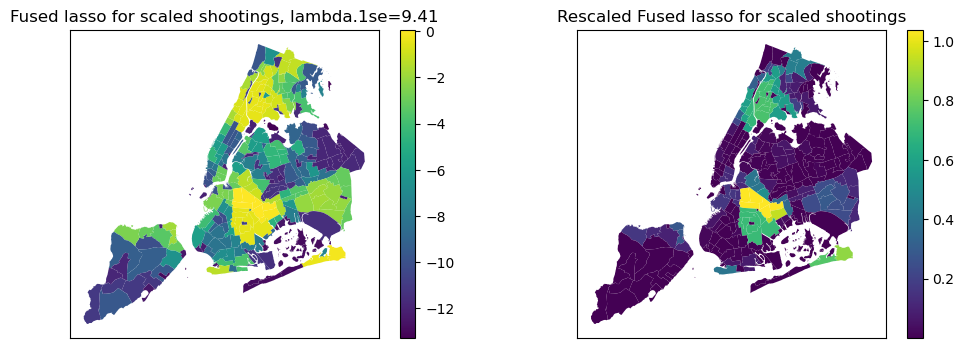

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
i= 1
gdf2['fused_lasso_2L']= beta_values2L[i].T
gdf2.plot(column='fused_lasso_2L', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title(f'Fused lasso for scaled shootings, lambda.1se={round(lambd_values2L[i],2)}')
ax[0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

gdf2['fused_lasso_2Lt']= (2**(beta_values2L[i])).T
gdf2.plot(column='fused_lasso_2Lt', ax=ax[1], legend=True, cmap='viridis')
ax[1].set_title(f'Rescaled Fused lasso for scaled shootings')
ax[1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
